In [1]:
import pandas as pd
import io
import re
import csv
import json
import numpy as np
from tqdm import tqdm
import math
import ast
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import seaborn as sns
import keras
from keras import backend as K
from progressbar import ProgressBar
import matplotlib.pyplot as plt
from keras import Sequential, Model
from random import randrange
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing
from keras.utils.vis_utils import plot_model

from plot_figures import save_model

pbar = ProgressBar()
tqdm.pandas()

Using TensorFlow backend.


In [2]:
max_blocks = 37 #(36 + 1 FC layer at the end)
#max_blocks = 36

nb_param =7
nb_hw_param = 6
#nb_param =12

BATCH_SIZE = 2048
SHUFFLE_BUFFER_SIZE = 100

DATASET_SIZE = 150894
train_size = int(0.90 * DATASET_SIZE) #135 805
test_size = int(0.10 * DATASET_SIZE) # 15 089

nb_training_batches = train_size //BATCH_SIZE +1
nb_test_batches = test_size //BATCH_SIZE +1

In [3]:

def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.asarray(ast.literal_eval(array_string))

# Load Proccessed Neural Networks (without HyperParameters)

In [4]:

path_raw_val = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/parsed_nondups_val1.csv'
path_raw_train = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/parsed_nondups_train1.csv'


path_processed_val_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/val_7.csv'
path_processed_train_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/train_7.csv'

In [5]:
#%pycache

val = pd.read_csv(path_processed_val_nn,converters={'NN_dataframe': from_np_array})
train = pd.read_csv(path_processed_train_nn,converters={'NN_dataframe': from_np_array})

# Complete to zeros (max shape)

In [6]:
def add_zero_blocks(arr):
    zero_blocks = np.zeros((max_blocks-arr.shape[0],arr.shape[1]))
    return np.append(arr, zero_blocks, axis=0)

val['NN_dataframe']= val['NN_dataframe'].apply(lambda x : add_zero_blocks(x))
train['NN_dataframe']= train['NN_dataframe'].apply(lambda x : add_zero_blocks(x))




# Get y_train, y_val


In [7]:
# To retrieve y_train / y_test

train_hw = pd.read_csv(path_raw_train)
val_hw = pd.read_csv(path_raw_val)

y_train = np.array(train_hw["total_power"].tolist())
y_train=y_train.reshape(y_train.shape[0],-1)

y_val = np.array(val_hw["total_power"].tolist())
y_val=y_val.reshape(y_val.shape[0],-1)

--------
# HW PARAM ALONE

In [8]:
X_train_hw_param  = train_hw[['mac_num', 'mac_array_num', 'data_bits', 'sram_size', 'max_filter_size']]
X_train_hw_param['tot_mac'] = X_train_hw_param['mac_num']*X_train_hw_param['mac_array_num']

X_val_hw_param  = val_hw[['mac_num', 'mac_array_num', 'data_bits', 'sram_size', 'max_filter_size']]
X_val_hw_param['tot_mac'] = X_val_hw_param['mac_num']*X_val_hw_param['mac_array_num']

X_train_hw_param.head()

,mac_num,mac_array_num,data_bits,sram_size,max_filter_size,tot_mac
0,118.0,2.0,256.0,179968.0,2048.0,236.0
1,87.0,2.0,512.0,99968.0,2048.0,174.0
2,124.0,2.0,512.0,99968.0,3072.0,248.0
3,80.0,2.0,1024.0,99968.0,1024.0,160.0
4,86.0,2.0,512.0,60000.0,1536.0,172.0


## HW Normalize

In [9]:
# normalize

#%pycache
# Process
scaler = preprocessing.StandardScaler().fit(X_train_hw_param)
X_train_hw_param_norm= scaler.transform(X_train_hw_param)
X_val_hw_param_norm = scaler.transform(X_val_hw_param )




## Dataset for HW param

In [10]:

X_hw_norm = np.concatenate((X_train_hw_param_norm, X_val_hw_param_norm))
y = np.concatenate((y_train, y_val))

# Mix train/test
dataset_hw_norm = tf.data.Dataset.from_tensor_slices((X_hw_norm, y))
#dataset_hw = dataset_hw.shuffle(SHUFFLE_BUFFER_SIZE)

# Split them
train_dataset_hw_norm =  dataset_hw_norm.take(train_size).batch(BATCH_SIZE)
test_dataset_hw_norm = dataset_hw_norm.skip(train_size).batch(BATCH_SIZE)

#test_dataset_hw = dataset_hw.take(test_size).batch(BATCH_SIZE)
#train_dataset_hw = dataset_hw.skip(test_size).batch(BATCH_SIZE)


#UNORMED
X_hw = np.concatenate((X_train_hw_param, X_val_hw_param))
# Mix train/test
dataset_hw = tf.data.Dataset.from_tensor_slices((X_hw, y))

# Split them
train_dataset_hw =  dataset_hw.take(train_size).batch(BATCH_SIZE)
test_dataset_hw = dataset_hw.skip(train_size).batch(BATCH_SIZE)

#test_dataset_hw = dataset_hw.take(test_size).batch(BATCH_SIZE)
#train_dataset_hw = dataset_hw.skip(test_size).batch(BATCH_SIZE)

------------

# NN TREATEMENT ALONE

In [11]:
X_train_nn =np.array(train['NN_dataframe'].tolist())
X_val_nn = np.array(val['NN_dataframe'].tolist())

## NN Normalize

In [12]:

#Reshape
train_reshape= X_train_nn.reshape(X_train_nn.shape[0], -1)
val_reshape= X_val_nn.reshape(X_val_nn.shape[0], -1)

# Process
scaler = preprocessing.StandardScaler().fit(train_reshape)
train_scaled= scaler.transform(train_reshape)
val_scaled = scaler.transform(val_reshape)

#Re-reshape
X_train_nn_norm= train_scaled.reshape(X_train_nn.shape)
X_val_nn_norm= val_scaled.reshape(X_val_nn.shape)

## Dataset for NN

In [13]:

X_nn = np.concatenate((X_train_nn_norm, X_val_nn_norm))
y = np.concatenate((y_train, y_val))

# Mix test/train 
dataset_nn = tf.data.Dataset.from_tensor_slices((X_nn, y))
dataset_nn= dataset_nn.shuffle(SHUFFLE_BUFFER_SIZE)

# Split them
test_dataset_nn = dataset_nn.take(test_size).batch(BATCH_SIZE)
train_dataset_nn = dataset_nn.skip(test_size).batch(BATCH_SIZE)



# Full Dataset (HW_params + NN arrays)

In [14]:

train_dataset_norm = tf.data.Dataset.from_tensor_slices(((X_train_nn_norm, X_train_hw_param_norm), y_train))
test_dataset_norm = tf.data.Dataset.from_tensor_slices(((X_val_nn_norm, X_val_hw_param_norm), y_val))



### Shuffle train/test dataset

In [15]:
#%pycache
# Mix between train/test (mix networks)
full_dataset = train_dataset_norm.concatenate(test_dataset_norm)
full_dataset = full_dataset.shuffle(SHUFFLE_BUFFER_SIZE)

test_dataset_norm = full_dataset.take(test_size)
train_dataset_norm = full_dataset.skip(test_size)



### Small dataset

In [16]:
%pycache
mini_batches = 7

train_dataset_small =train_dataset_norm.take(mini_batches).batch(BATCH_SIZE)
test_dataset_small =test_dataset_norm.take(mini_batches).batch(BATCH_SIZE)

UsageError: Line magic function `%pycache` not found.


### Take batches

In [17]:
## shuffle batch
train_dataset_norm = train_dataset_norm.batch(BATCH_SIZE)
test_dataset_norm = test_dataset_norm.batch(BATCH_SIZE)

# Get loss/model

## Models

In [18]:

model_nn= tf.keras.Sequential([
      layers.Conv1D(64, (3), activation='relu', padding="same",input_shape=(max_blocks, 7)),
      layers.Conv1D(32, (3), activation='relu', padding="same"),
      layers.Conv1D(32, (3), activation='relu', padding="same"),
      layers.Conv1D(1, (3), activation='relu', padding="same"),
      layers.Lambda( lambda x: K.sum(x, axis=1)),
     #layers.Flatten()
])


model_hw = tf.keras.Sequential([
     layers.Dense(16, activation='relu', input_shape=(6,)),
     #layers.Dense(64, activation='relu'),
     layers.Dense(32, activation='relu'),
     #layers.Dense(16, activation='relu'),
     layers.Dense(1, activation='linear')
 ])

concat = tf.keras.layers.Concatenate()([model_nn.output, model_hw.output])
output = tf.keras.layers.Dense(units=10, activation='relu')(concat)
output = tf.keras.layers.Dense(units=1, activation='relu')(output)
full_model = tf.keras.Model(inputs=[model_nn.input, model_hw.input], outputs=[output])

In [19]:
def loss(target_power, predicted_power):
  return tf.math.abs((target_power - predicted_power)/target_power)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=nb_training_batches,
    decay_rate=0.95)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Test on HW only

###
137,090 HW parameters
68,503 unique ones </br>

137,090 power estimation
121,602 unique ones

In [20]:
 print(f'PARAMS : {model_hw.count_params()}')
model_hw.compile(optimizer=optimizer, loss=loss)
hw = model_hw.fit(train_dataset_hw_norm,
            validation_data=(test_dataset_hw_norm),
            epochs=10,
            verbose=1)

# hw = model_hw.fit(train_dataset_hw,
#             validation_data=(test_dataset_hw),
#             epochs=20,
#             verbose=1)



PARAMS : 689
Epoch 1/10
67/67 [==============================] - 3s 42ms/step - loss: 0.8092 - val_loss: 0.0000e+00
Epoch 2/10
67/67 [==============================] - 2s 26ms/step - loss: 0.7282 - val_loss: 0.6311
Epoch 3/10
67/67 [==============================] - 2s 26ms/step - loss: 0.7231 - val_loss: 0.6239
Epoch 4/10
67/67 [==============================] - 2s 25ms/step - loss: 0.7205 - val_loss: 0.6191
Epoch 5/10
67/67 [==============================] - 2s 26ms/step - loss: 0.7181 - val_loss: 0.6163
Epoch 6/10
67/67 [==============================] - 2s 25ms/step - loss: 0.7158 - val_loss: 0.6146
Epoch 7/10
67/67 [==============================] - 2s 25ms/step - loss: 0.7140 - val_loss: 0.6134
Epoch 8/10
67/67 [==============================] - 2s 26ms/step - loss: 0.7128 - val_loss: 0.6121
Epoch 9/10
67/67 [==============================] - 2s 26ms/step - loss: 0.7114 - val_loss: 0.6111
Epoch 10/10
67/67 [==============================] - 2s 25ms/step - loss: 0.7104 - val_loss:

5218
pred : [[33.567047]]
true : [20.37065642]

loss : [[0.64781372]]
7239
pred : [[19.65272]]
true : [69.16454549]

loss : [[0.71585558]]
10765
pred : [[14.308579]]
true : [12.96964775]

loss : [[0.10323578]]
10607
pred : [[14.350251]]
true : [14.4726893]

loss : [[0.00845994]]
1811
pred : [[12.614699]]
true : [13.06091858]

loss : [[0.03416446]]
12286
pred : [[17.44063]]
true : [42.45670634]

loss : [[0.58921378]]
9467
pred : [[14.365403]]
true : [5.26140558]

loss : [[1.73033564]]
7354
pred : [[17.024271]]
true : [96.7947882]

loss : [[0.82411996]]
7773
pred : [[21.569382]]
true : [82.93795863]

loss : [[0.73993354]]
10957
pred : [[14.5600195]]
true : [15.35590861]

loss : [[0.0518295]]
6942
pred : [[13.3049555]]
true : [47.75953947]

loss : [[0.72141784]]
10723
pred : [[14.163066]]
true : [15.53478529]

loss : [[0.08829986]]
1826
pred : [[15.361293]]
true : [19.69318093]

loss : [[0.21996894]]
5604
pred : [[17.074465]]
true : [19.24266489]

loss : [[0.11267671]]
7700
pred : [[12.34

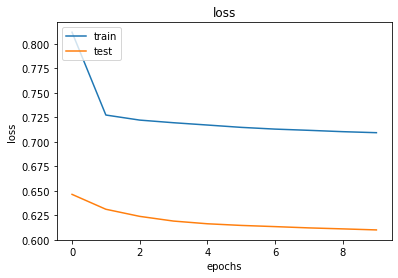

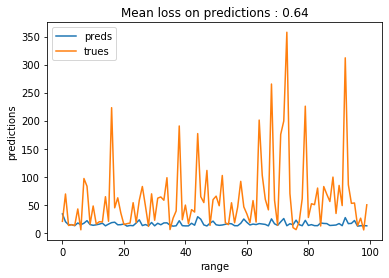

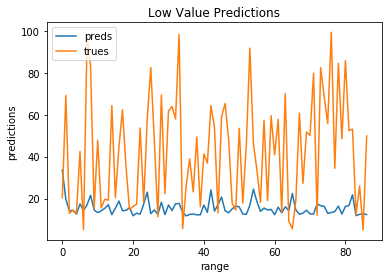

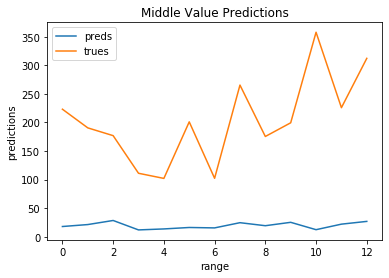

<Figure size 432x288 with 0 Axes>

In [21]:

name = f'{model_hw.count_params()}_param'
nb_predictions = 100
max_val_loss=0.70
nb_final_epochs_for_mean = 3 
save = True

path = "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/test/fc"
model = model_hw
X_list = [X_val_hw_param_norm]
history = hw

#model = full_model
#X_list = [X_val_hw_param_norm, X_val_nn_norm]

save_model(path=path, model= model, history=history, X_list=X_list, y=y_val, name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean, save = save )

## Test on NN only

In [22]:
print(model_nn.count_params())
model_nn.compile(optimizer=optimizer, loss=loss)

nn = model_nn.fit(train_dataset_nn,
          validation_data=(test_dataset_nn),
          epochs=10,
          verbose=1,
          #callbacks=[TestCallback((test_dataset)) ] )
)

10785
Epoch 1/10
67/67 [==============================] - 16s 242ms/step - loss: 0.5685 - val_loss: 0.0000e+00
Epoch 2/10
67/67 [==============================] - 13s 198ms/step - loss: 0.4757 - val_loss: 0.4351
Epoch 3/10
67/67 [==============================] - 13s 199ms/step - loss: 0.4320 - val_loss: 0.4337
Epoch 4/10
67/67 [==============================] - 13s 200ms/step - loss: 0.4066 - val_loss: 0.3681
Epoch 5/10
67/67 [==============================] - 14s 203ms/step - loss: 0.3745 - val_loss: 0.3601
Epoch 6/10
67/67 [==============================] - 13s 198ms/step - loss: 0.3666 - val_loss: 0.3243
Epoch 7/10
67/67 [==============================] - 13s 198ms/step - loss: 0.3490 - val_loss: 0.3229
Epoch 8/10
67/67 [==============================] - 13s 199ms/step - loss: 0.3320 - val_loss: 0.3365
Epoch 9/10
67/67 [==============================] - 13s 197ms/step - loss: 0.3264 - val_loss: 0.3277
Epoch 10/10
67/67 [==============================] - 13s 199ms/step - loss: 0.317

52
pred : [[31.254328]]
true : [54.41981154]

loss : [[0.42568107]]
12761
pred : [[26.65696]]
true : [62.42187334]

loss : [[0.57295483]]
4925
pred : [[228.77646]]
true : [315.61080603]

loss : [[0.2751311]]
11212
pred : [[29.338608]]
true : [28.84315431]

loss : [[0.01717751]]
10043
pred : [[43.022526]]
true : [32.10630709]

loss : [[0.34000231]]
7796
pred : [[68.06188]]
true : [85.80096797]

loss : [[0.20674692]]
12052
pred : [[26.65696]]
true : [44.30024785]

loss : [[0.39826613]]
12684
pred : [[26.65696]]
true : [74.83425348]

loss : [[0.64378666]]
11591
pred : [[14.555959]]
true : [11.59181012]

loss : [[0.25571059]]
960
pred : [[104.018555]]
true : [105.6998082]

loss : [[0.01590593]]

y_pred_min : [[14.555959]]
y_pred_max : [[228.77646]]
diff : [[214.2205]]
Mean loss on predictions : 0.31513630498840495
No High Value Predictions


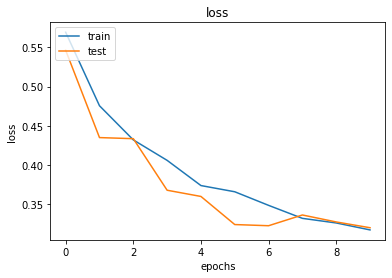

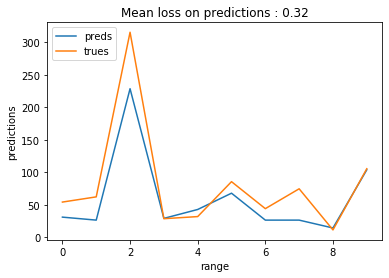

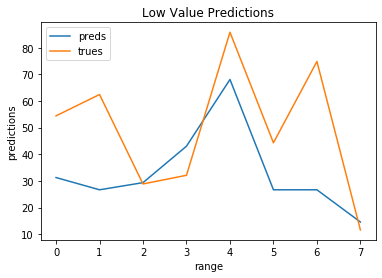

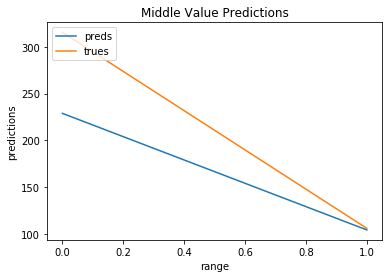

<Figure size 432x288 with 0 Axes>

In [23]:

name = f'{model_nn.count_params()}_param'
save = True
nb_predictions = 100
max_val_loss=0.51
nb_final_epochs_for_mean = 1


path = "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/test/conv1D"
model = model_nn
X_list = [X_val_nn_norm]
history = nn

#model = full_model
#X_list = [X_val_hw_param_norm, X_val_nn_norm]

save_model(path=path, model= model, history=history, X_list=X_list, y=y_val, name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean , save = save)

# Test entire model

In [24]:
 print(f'PARAMS : {model_nn.count_params()}')

full_model.compile(optimizer=optimizer, loss=loss)
# history = full_model.fit(train_dataset_small,
#         validation_data=(test_dataset_small),
#         epochs=10,
#         verbose=1,
#         #callbacks=[TestCallback((test_dataset)) ] )
# )

history = full_model.fit(train_dataset_norm,
        validation_data=(test_dataset_norm),
        epochs=50,
        verbose=1,
        #callbacks=[TestCallback((test_dataset)) ] )
)

PARAMS : 10785
Epoch 1/50
67/67 [==============================] - 19s 286ms/step - loss: 0.3405 - val_loss: 0.0000e+00
Epoch 2/50
67/67 [==============================] - 16s 236ms/step - loss: 0.3055 - val_loss: 0.3288
Epoch 3/50
67/67 [==============================] - 16s 237ms/step - loss: 0.2984 - val_loss: 0.3185
Epoch 4/50
67/67 [==============================] - 16s 239ms/step - loss: 0.2914 - val_loss: 0.3033
Epoch 5/50
67/67 [==============================] - 16s 237ms/step - loss: 0.2884 - val_loss: 0.2911
Epoch 6/50
67/67 [==============================] - 16s 236ms/step - loss: 0.2742 - val_loss: 0.2881
Epoch 7/50
67/67 [==============================] - 16s 236ms/step - loss: 0.2695 - val_loss: 0.2786
Epoch 8/50
67/67 [==============================] - 16s 237ms/step - loss: 0.2709 - val_loss: 0.2736
Epoch 9/50
67/67 [==============================] - 16s 236ms/step - loss: 0.2595 - val_loss: 0.2634
Epoch 10/50
67/67 [==============================] - 16s 236ms/step - lo

12993
pred : [[2935.419]]
true : [3582.8398406]

loss : [[0.18070048]]
1933
pred : [[13.859293]]
true : [13.7961067]

loss : [[0.00458001]]
4676
pred : [[44.386765]]
true : [65.86112709]

loss : [[0.32605519]]
11528
pred : [[7.3473916]]
true : [9.01948304]

loss : [[0.18538662]]
834
pred : [[101.35426]]
true : [99.48956596]

loss : [[0.01874264]]
12400
pred : [[43.021885]]
true : [43.45204765]

loss : [[0.00989971]]
4317
pred : [[33.77251]]
true : [25.99124378]

loss : [[0.29938031]]
9590
pred : [[4.753109]]
true : [5.3510805]

loss : [[0.11174781]]
2424
pred : [[184.74034]]
true : [218.88310311]

loss : [[0.15598628]]
4753
pred : [[40.942963]]
true : [56.01049829]

loss : [[0.2690127]]
7837
pred : [[83.883156]]
true : [71.57298064]

loss : [[0.17199473]]
4346
pred : [[36.921894]]
true : [29.82164554]

loss : [[0.23809043]]
9233
pred : [[18.900663]]
true : [15.89892279]

loss : [[0.18880151]]
6144
pred : [[12.736434]]
true : [15.52707921]

loss : [[0.17972764]]
9928
pred : [[155.56914]

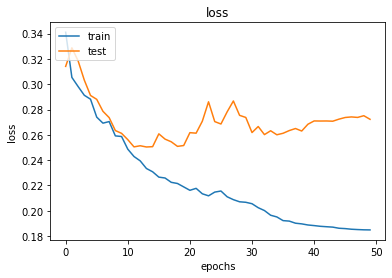

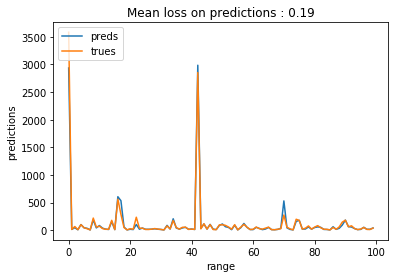

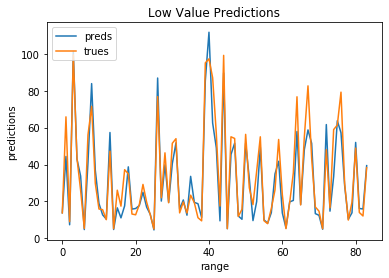

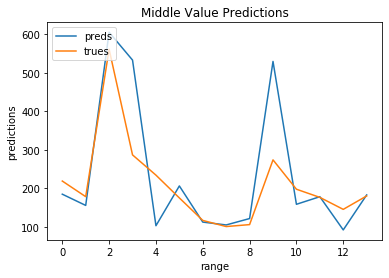

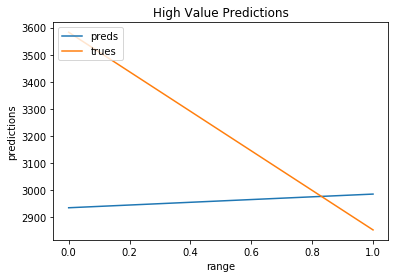

In [25]:
nb_final_epochs_for_mean = 3 
name = f'{full_model.count_params()}_param'
save = True

nb_predictions = 100
max_val_loss=0.30


path = "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/multiple_inputs"
model = full_model
X_list = [X_val_nn_norm, X_val_hw_param_norm]
history = history

#model = full_model
#X_list = [X_val_hw_param_norm, X_val_nn_norm]

save_model(path=path, model= model, history=history, X_list=X_list, y=y_val, name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean, save=save)